In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from math import sqrt
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from IPython.display import FileLink

# Housing Prices: One Feature Solution

This notebook serves as a very light intro to the Kaggle Housing Prices problem, attempting to solve the problem using only 1 feature.

Contents:

  1. Download the dataset.
  2. Load and explore dataset.
  3. Linear Regression exploration.
  4. Training a model.
  5. Submit predictions.

Firstly, setup the data directory:

In [2]:
PATH = Path('./data')

In [3]:
PATH.mkdir(exist_ok=True)

## 1. Download the dataset

Kaggle provides a CLI that makes downloading datasets easy. To use it, install it using Pip:

```
pip install kaggle
```

Then download your Kaggle API key from `My Account` and save to `~/.kaggle/kaggle.json`. You should then make it readable only to yourself:

```
chmod 600 ~/.kaggle/kaggle.json
```

You can then download the data as follows:

In [7]:
!kaggle competitions download -c house-prices-advanced-regression-techniques -p {PATH}

data_description.txt: Skipping, found more recently modified local copy (use --force to force download)
train.csv.gz: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv.gz: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.gz: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


## 2. Load and explore data

We can use Pandas to load the CSV in one line:

In [4]:
df_raw = pd.read_csv(PATH / 'train.csv')

In [5]:
df_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


A lot of the values have linear relationships with the sale price. We can plot a few examples to highlight this.

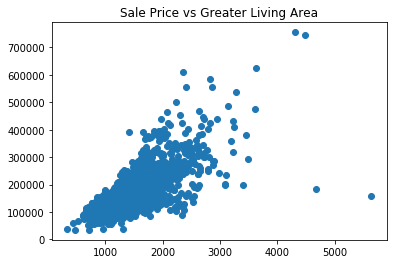

In [6]:
plt.scatter(x=df_raw['GrLivArea'], y=df_raw['SalePrice'])
plt.title('Sale Price vs Greater Living Area')
plt.show()

We can also create a new feature which combines square footage from the greater living area, the basement, the garage and porch and plot that.

In [7]:
df_raw['TotalSF'] = (
    df_raw['GrLivArea'] +
    df_raw['TotalBsmtSF'] +
    df_raw['GarageArea'] +
    df_raw['EnclosedPorch'] +
    df_raw['ScreenPorch']
)

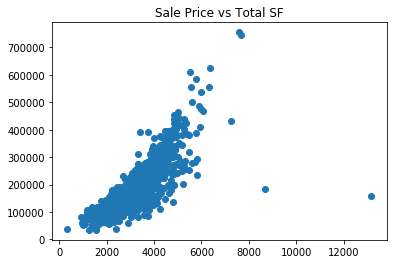

In [8]:
plt.scatter(x=df_raw['TotalSF'], y=df_raw['SalePrice'])
plt.title('Sale Price vs Total SF')
plt.show()

Appears to be a very clear linear relationship. There appears to be 2 outliers - huge plots with low prices. We'll look into cleaning them out shortly.

## 3. Linear Regression exploration

The goal of linear regression is to fit a line through data. The goal of linear regression is to discover an intercept and coefficient that minimises the error in this equation $\text{SalePrice} = \text{intercept} + \text{coefficient} \cdot \text{TotalSF}$

We'll calculate error using [root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation). All that means is for each data point (dot in the above plot), we'll calculate our equation using some learned $\text{intercept}$ and $\text{coefficient}$ values, then figure out the error by subtracting the y actual from y predicted (denoted as $\hat{y}$):

$y - \hat{y}$

Then, we'll square that result which does 2 things:

1. Ensures the error is a positive value ($-1^2 = 1$) 
2. Maximises larger error values.

We'll then turn it into a single number by taking the mean of all our predictions, then taking the square root of that.

We can train a linear regression model using the `LinearRegression` class in Scikit learn.

In [9]:
model = LinearRegression()

To find **intercept** and **coefficient** values, the Linear Regression model will perform gradient descent to find values that minimise the error. We can do that by calling `fit` on the model passing in our independant variable, `TotalSF` and our dependant variable, `SalePrice`.

In [11]:
model.fit(df_raw[['TotalSF']], df_raw['SalePrice'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now let's take a look at the intercept and coefficient learned:

In [12]:
model.intercept_, model.coef_

(-22571.56531273364, array([66.00717823]))

We can apply the equation on all our data points as follows:

In [13]:
predicted_values = (model.intercept_ + df_raw['TotalSF'] * model.coef_[0])

Let's create the same scatterplot this time displaying the line for our predicted values:

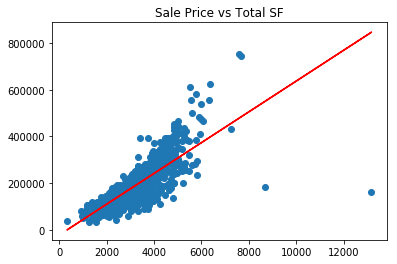

In [14]:
plt.scatter(x=df_raw['TotalSF'], y=df_raw['SalePrice'])
plt.plot(df_raw['TotalSF'], predicted_values, color='red')
plt.title('Sale Price vs Total SF')
plt.show()

We can calculate our RMSE as follows:

In [15]:
def rmse(actual, predictions):
    errors = actual - predictions
    errors_squared = errors ** 2
    errors_squared_mean = errors_squared.mean()
    root_mean_squared_error = sqrt(errors_squared_mean)
    return root_mean_squared_error

In [16]:
rmse(df_raw['SalePrice'], predicted_values)

47487.811209595064

So our predictions are off by around 47k on the training set.

### Removing outliers

Since we can see 2 clear outliers that may be affecting our fit, let's try removing them. They appear to be over 8000 SF and below $400k SalePrice. We can remove those using Pandas:

In [17]:
len(df_raw)

1460

In [18]:
idx_to_drop = df_raw[(df_raw['TotalSF'] > 8000) & (df_raw['SalePrice'] < 400000)].index

In [19]:
df_raw.drop(idx_to_drop, inplace=True)

Let's now refit the line:

In [20]:
model = LinearRegression()
model.fit(df_raw[['TotalSF']], df_raw['SalePrice'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We can get our predicted values using the `predict` method, instead of calculating it ourselves:

In [21]:
predicted_values = model.predict(df_raw[['TotalSF']])

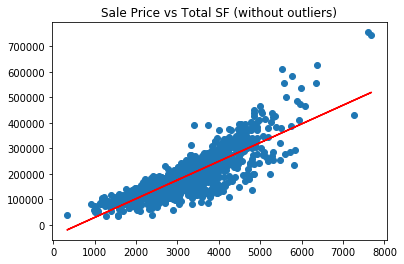

In [22]:
plt.scatter(x=df_raw['TotalSF'], y=df_raw['SalePrice'])
plt.plot(df_raw['TotalSF'], predicted_values, color='red')
plt.title('Sale Price vs Total SF (without outliers)')
plt.show()

In [23]:
rmse(df_raw['SalePrice'], predicted_values)

42385.7442159878

That appear to have helped our RMSE a bit. Down to a mean error of $42k. That's pretty reasonable!

One other small optimisation we can make it to reduce the spread of the `SalePrice` datapoints. Let's start by taking a look at the distribution of the `SalePrice`:

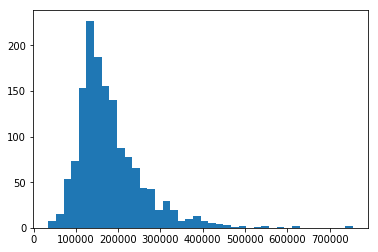

In [24]:
plt.hist(df_raw['SalePrice'], bins=40)
plt.show()

We can see a big rightside tail, which may be making it harder to fit a line. We also know that the competition requires us to calculate the RMSE on the log of Sale Price. So let's do that.

In [25]:
df_raw['SalePrice'] = np.log(df_raw['SalePrice'])

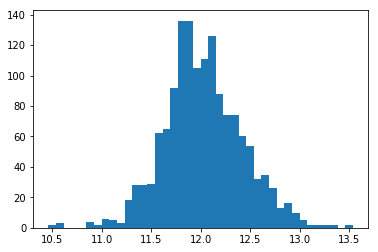

In [26]:
plt.hist(df_raw['SalePrice'], bins=40)
plt.show()

That seems a bit less skewed. Let's see how we go fitting a line now:

In [27]:
model = LinearRegression()
model.fit(df_raw[['TotalSF']], df_raw['SalePrice'])
log_preds = model.predict(df_raw[['TotalSF']])

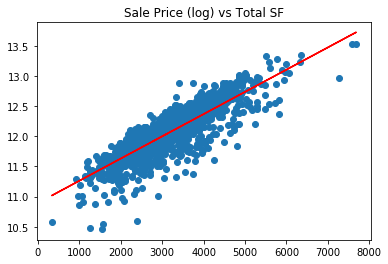

In [28]:
plt.scatter(x=df_raw['TotalSF'], y=df_raw['SalePrice'])
plt.plot(df_raw['TotalSF'], log_preds, color='red')
plt.title('Sale Price (log) vs Total SF')
plt.show()

That looks like a pretty damn good fit. Let's see our RMSE now. Note that I'll reverse the log on the predictions using `np.exp`.

In [29]:
rmse(np.exp(df_raw['SalePrice']), np.exp(log_preds))

41580.19922208228

A slight improvement.

It's important to note that we shouldn't trust our model results yet until we validate it on a set of TotalSF to SalePrice that it hasn't seen during training. Otherwise, we could be *overfitting* the model.

So let's do that.

## 4. Training a model

It's good practise to start by creating a validation set. Scikit-learn provides a function called `train_test_split` that shuffles the input data and allocates a portion to training and a portion to validation.

We'll pass a `random_state` argument to ensure the split is consistent.

In [30]:
total_sqft_train, total_sqft_val, sale_price_train, sale_price_val = (
    train_test_split(df_raw[['TotalSF']], df_raw['SalePrice'], test_size=0.2, random_state=42)
)

In [31]:
print(f'Train set size: {len(total_sqft_train)}')
print(f'Val set size: {len(total_sqft_val)}')

Train set size: 1166
Val set size: 292


Let's retrain our model and evaluate the results on our validation set.

In [32]:
model = LinearRegression()
model.fit(total_sqft_train, sale_price_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
val_predictions = model.predict(total_sqft_val)

First, we'll see how the fit looks.

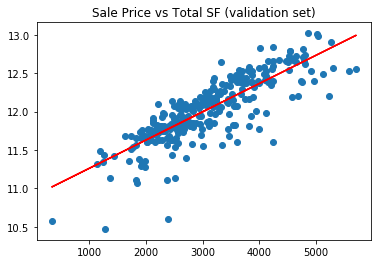

In [34]:
plt.scatter(x=total_sqft_val, y=sale_price_val)
plt.plot(total_sqft_val, val_predictions, color='red')
plt.title('Sale Price vs Total SF (validation set)')
plt.show()

Then let's look at our RMSE.

In [35]:
rmse(np.exp(sale_price_val), np.exp(val_predictions))

42644.28299948632

That's pretty good! The competition calculates the RMSE using the log of the sale price and predictions, so let's see how our model would fair using that evaluation metric.

In [36]:
rmse(sale_price_val, val_predictions)

0.22966457005102117

That would put us at about position 4847th on the leaderboard. Which is about the top 90%. Lot's of room to improve but a great start.

Let's create a submission.

## 5. Submit predictions

Kaggle accepts submissions for this competition by way of a CSV with the house id in one column and a sale price in another. You can see an example of that using the `sample_submission.csv` file:

In [37]:
!head -n 3 {PATH}/sample_submission.csv

Id,SalePrice
1461,169277.0524984
1462,187758.393988768


We can load our test dataset, then perform the same preprocessing we performed to train our model.

Note that we also fill any missing values with 0 in this example, since there are a few in the test set.

In [38]:
test_df = pd.read_csv(PATH / 'test.csv')

In [39]:
test_df['TotalSF'] = (
    test_df['GrLivArea'] +
    test_df['TotalBsmtSF'].fillna(0) +
    test_df['GarageArea'].fillna(0) +
    test_df['EnclosedPorch'].fillna(0) +
    test_df['ScreenPorch'].fillna(0)
)

In [40]:
test_preds = model.predict(test_df[['TotalSF']])

We can generate a submission file using the `to_csv` method in Pandas.

In [41]:
pd.DataFrame(
    {'Id': test_df['Id'], 'SalePrice': np.exp(test_preds)}
).to_csv(PATH / 'sub.csv', index=False)

In [42]:
FileLink(PATH / 'sub.csv')

/Users/lex/code/notebooks/kaggle/house-prices-advanced-regression-techniques/data/sub.csv

That gives a score of 0.23194 on the leaderboard, putting us around 4861th.

Next up: our first categorical features.